In [1]:
#Importing libraries 
import pandas as pd
import numpy as np
import pydicom 

import os
import random

#Visualisation 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore");
%matplotlib inline

In [3]:
INPUT_PATH = '../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/'

In [4]:
os.listdir(INPUT_PATH)

['stage_2_train',
 'stage_2_test',
 'stage_2_sample_submission.csv',
 'stage_2_train.csv']

# **Exploratory analysis**

Let us try exploring this dataset, to get some insights and understand our data better

In [5]:
sub = pd.read_csv(INPUT_PATH+"stage_2_sample_submission.csv")
sub.head(10)

,ID,Label
0,ID_0fbf6a978_epidural,0.5
1,ID_0fbf6a978_intraparenchymal,0.5
2,ID_0fbf6a978_intraventricular,0.5
3,ID_0fbf6a978_subarachnoid,0.5
4,ID_0fbf6a978_subdural,0.5
5,ID_0fbf6a978_any,0.5
6,ID_d62ec3412_epidural,0.5
7,ID_d62ec3412_intraparenchymal,0.5
8,ID_d62ec3412_intraventricular,0.5
9,ID_d62ec3412_subarachnoid,0.5


So Image IDs of form ID_SUBTYPE, which means we would have to make predictions for each subtype under a image ID. 
`any` --> indicates there is at least one subtype present telling us that patient has IH or not
`Label` --> indicates probability of presence

In [6]:
train_df = pd.read_csv(INPUT_PATH+"stage_2_train.csv")
# train_df.head(10)
labels =  train_df.Label.values

The training dataset is provided as set image`Id` and **multiple labels**, one for each of the subtypes of hemorrhage along with an addition lable for `any`(will be true of any of the subtype labels in true). So this is a **multilable classification task**.

Lets split the ID into columns of images and the corresponding diagnosis(subtype)

In [7]:
train_df = train_df.ID.str.rsplit("_",n=1,expand=True)
train_df.loc[:, "label"] = labels
train_df.head()

,0,1,label
0,ID_12cadc6af,epidural,0
1,ID_12cadc6af,intraparenchymal,0
2,ID_12cadc6af,intraventricular,0
3,ID_12cadc6af,subarachnoid,0
4,ID_12cadc6af,subdural,0


In [8]:
train_df = train_df.rename({0 : "image",1 : "subtype"}, axis=1)

## Look into target distribution

In [9]:
#find the count of targets under each subtype
subtype_count = train_df.groupby("subtype").label.value_counts().unstack()
subtype_count

label,0,1
subtype,,
any,644874,107933
epidural,749662,3145
intraparenchymal,716689,36118
intraventricular,726602,26205
subarachnoid,717132,35675
subdural,705641,47166


In [10]:
#calculating the % target distribution across each subtype
subtype_count_per =  subtype_count.loc[:,1]/train_df.groupby("subtype").size() *100

multi_target_count = train_df.groupby("image").label.sum()

In [11]:
#Helper function
def random_colors(num_colors : int):
    colors = []
    for i in range(num_colors):
        colors.append('#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors 

Lets ask questions and try finding answers to it through visualisations :
1. How many positive and negative targets do we see in the training dataset?
2. What is the target distribution across each of the labels ?
3. Is the dataset imbalanced ?

Text(0.5, 1.0, 'Imbalance in target distrubution')

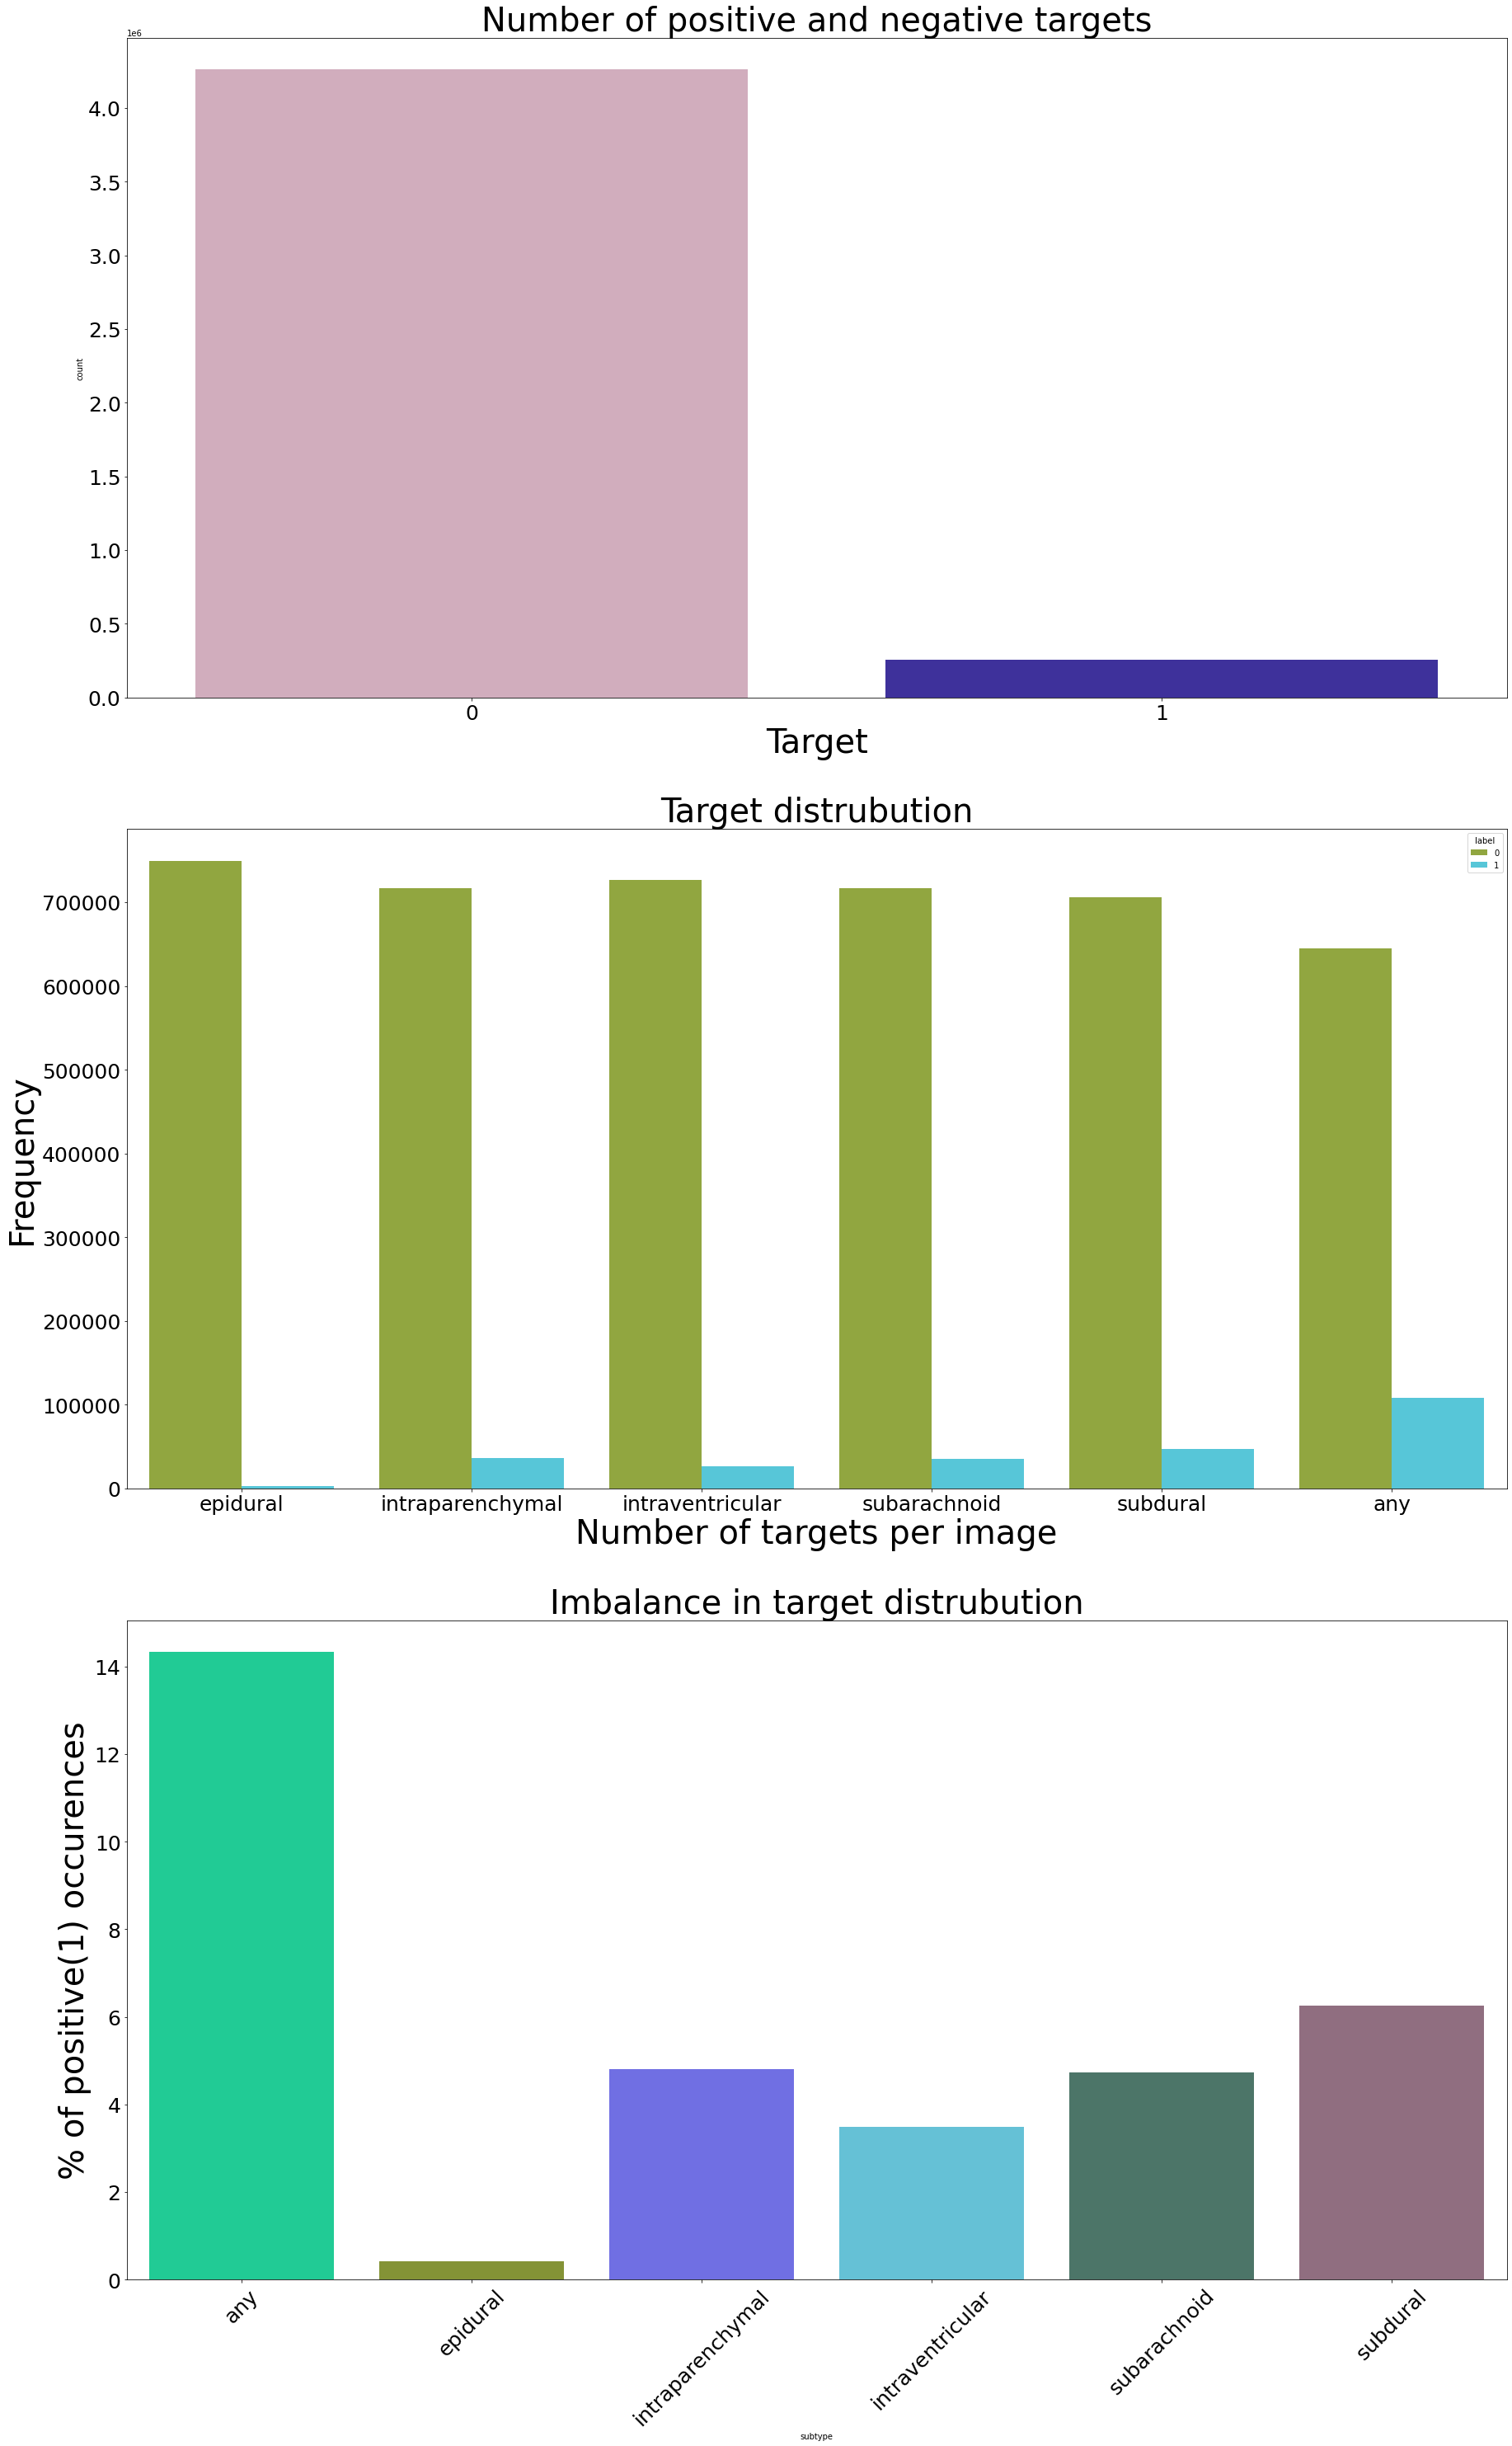

In [12]:
fig, ax = plt.subplots(3,1, figsize=(30,50))

sns.countplot(train_df.label,ax=ax[0], palette=random_colors(2))
ax[0].set_xlabel("Target", fontsize=40)
ax[0].tick_params(axis='x', labelsize=25 ) 
ax[0].tick_params(axis='y', labelsize=25 ) 
ax[0].set_title("Number of positive and negative targets",fontsize=40)


sns.countplot(x="subtype", hue="label", data=train_df, ax=ax[1], palette=random_colors(6))
ax[1].set_xlabel("Number of targets per image",fontsize=40)
ax[1].set_ylabel("Frequency",fontsize=40)
ax[1].tick_params(axis='x', labelsize=25 ) 
ax[1].tick_params(axis='y', labelsize=25 ) 
ax[1].set_title("Target distrubution",fontsize=40)

sns.barplot(subtype_count_per.index, subtype_count_per.values, ax=ax[2], palette=random_colors(6))
plt.xticks(rotation=45)
ax[2].set_ylabel("% of positive(1) occurences",fontsize=40)
ax[2].tick_params(axis='x', labelsize=25 ) 
ax[2].tick_params(axis='y', labelsize=25 ) 
ax[2].set_title("Imbalance in target distrubution",fontsize=40)

So what do we make of it ?

- Less no of positive target values
- Epidural type has very few positive occurences(<1%)
- Highly Imbalanced

### Basic Checks before exploring images..

Compare counts of images provided in training dataset with the training files given to check 
everything is fine before proceeeding..

In [13]:
#Count of images in training dataset
train_df.image.nunique()

752803

In [14]:
train_files = os.listdir(INPUT_PATH+"stage_2_train")

In [15]:
#Actual no. of image files 
len(train_files)

752803

Ok. So no issues in training set.

In [16]:
test_files = os.listdir(INPUT_PATH+"stage_2_test")
len(test_files)

121232

In [17]:
len(train_files)/len(test_files)

6.209606374554573

So 6.2times more images in train dataset than test dataset

## Lets look into DICOM files

### **What is a DICOM ?**
Dicom is a format that has metadata, as well as Pixeldata attached to it. Below I extract some basic info with an image. You will know about the gender and age of the patient, as well as info how the image is sampled and generated. 

So lets look at some samples from our dataset

In [18]:
train_files[:5]

['ID_27a354d42.dcm',
 'ID_9ef779a18.dcm',
 'ID_5bed38bf6.dcm',
 'ID_286599272.dcm',
 'ID_bba76cea8.dcm']

Below are some of the slices from CT scans that are stored as pixel data in DICOM files

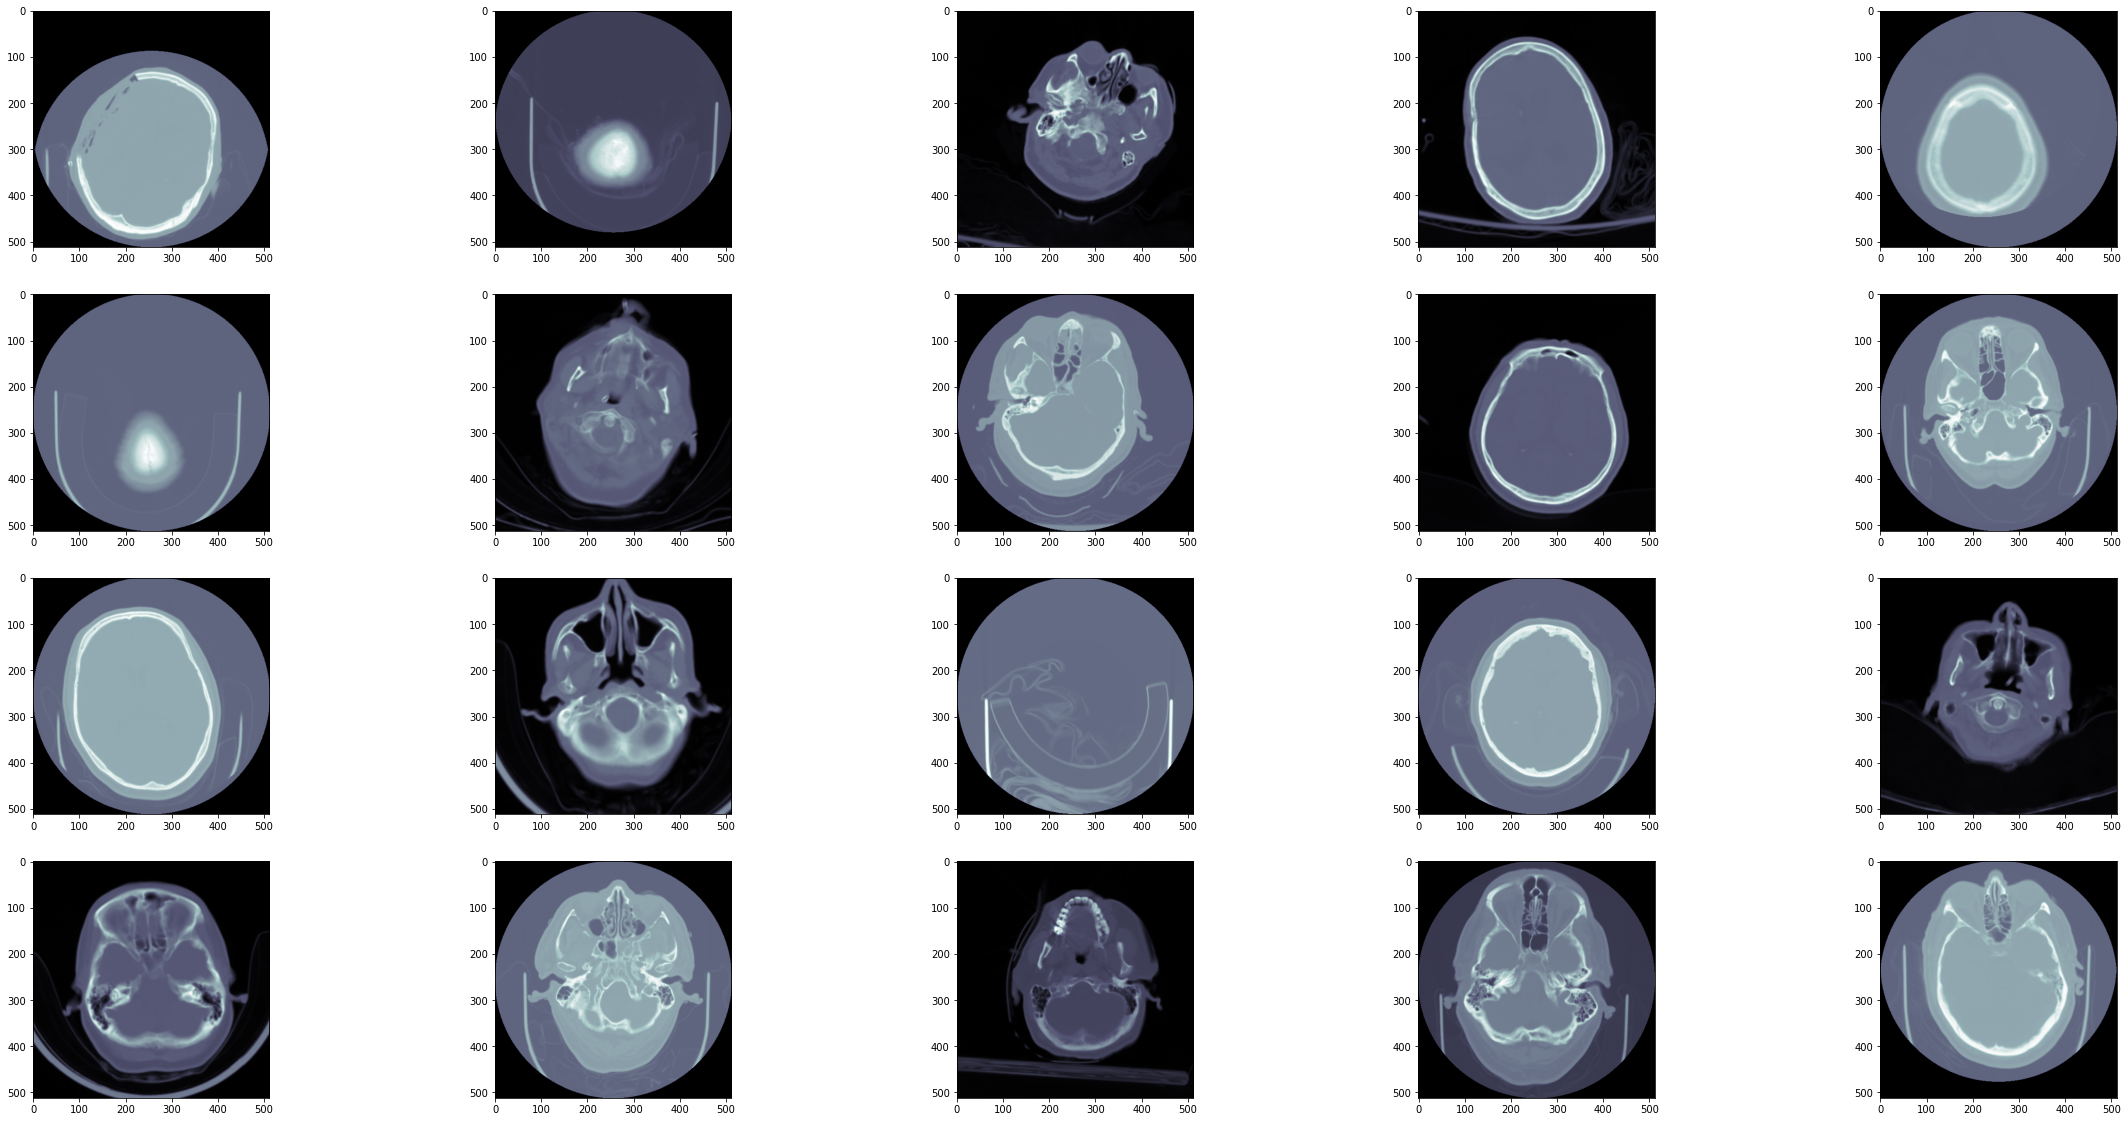

In [19]:
fig = plt.figure(figsize=(40,20))
column= 5; rows = 4
for i in range(1, column*rows +1):
    dcm = pydicom.dcmread(INPUT_PATH+"stage_2_train/"+train_files[i])
    fig.add_subplot(rows, column, i)
    plt.imshow(dcm.pixel_array, cmap=plt.cm.bone)
    fig.add_subplot

Look into the meta data that comes with the DICOM File, look for insights that can help us during processing 

In [20]:
print(dcm)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 188
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.4267.32.281664957337851357059828970761455249908
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: ID_d0bc20632
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_6a954d3e'
(0020, 000d) Study Instance UID                  UI: ID_c9ffa5cdfc
(0020, 000e) Series Instance UID                 UI: ID_dd1f514c4b
(0020, 0010) Study ID                            SH: '

As we see there are details about the sampling along with the patients details. 
Some of it(like Window center, Window width, Rescale Intercept) can help at better pre-processing of these DICOM files.

Lets look the pixel data of one sample and find out the shape of these images

In [21]:
image = dcm.pixel_array
print(type(image)) #format in which pixel data is stored
print(image.dtype) #datatype of the pixel values
print(image.shape) #shape of image(wxh)

<class 'numpy.ndarray'>
int16
(512, 512)


So images are of 512x512, we'll downsample them later to deal with the large training set

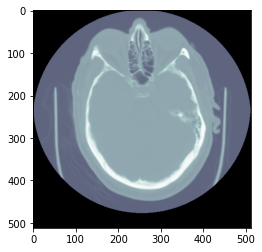

In [22]:
plt.imshow(image, cmap=plt.cm.bone)

DICOM images typically contain between 12–16 bits/pixel, which corresponds to approximately 4,096 to 65,536 shades of gray. But most regular computer screens are often limited to 8 bits or 256 shades of gray. 

Most images like the one above **display a wide range of tissue densities**(ranging from -1000HU(air) to +1000HU(bone)), but as mentioned above a **computer screen  can only display 256 shades of gray with our eye detecting only about a 6% change** in grayscale 

**Math around it :**
 Eye can detect only 6% change in grayscale, so `100/6 = 17 shades of gray`
 To display a DICOM(having range of approx, 2000HU) image on computer screen(can only display 256 shades pf gray) = `2000/256 = 8 --> each shade of gray would have diff of 8HU`
 
 Therefore, each variation would vary by `256/17*9 = 120HU`
 
 BUT, the difference between normal and pathologically altered tissue is usually a lot less than 120 HU 
 

So what to do? **Windowing !**

# **Getting into data preprocessing**

The point of applying windows is **to focus down the 256 shades of grey into a narrow region of HU(Hounsfiled units) that contain the relevnat densities of tissues we are interested** in while diagonising.

In [23]:
## A function to correct pixel data and rescale intercercepts ob 12 bit images
def dcm_correction(dcm_img):
        x = dcm_img.pixel_array + 1000
        px_mode = 4096
        x[x >= px_mode] = x[x >= px_mode] - px_mode #if there are extra bits in 12-bit grayscale(<=4096)
        dcm_img.PixelData = x.tobytes()
        dcm_img.RescaleIntercept = -1000 #setting a common value across all 12-bit US images

In [24]:
diff_size = []
for i in range(len(INPUT_PATH+"stage_2_train/")):
    dicom = pydicom.dcmread(INPUT_PATH+"stage_2_train/"+train_files[i])
    
    if dicom.BitsStored == 12:
        diff_size.append(dicom)

In [25]:
len(diff_size)

41

In [26]:
diff_size[1]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 176
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 9999.100856806108068519117393770543572330882
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.38'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: ID_286599272
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_7ba59d14'
(0020, 000d) Study Instance UID                  UI: ID_9f39f65610
(0020, 000e) Series Instance UID                 UI: ID_b55ce168f2
(0020, 0010) Study ID                            SH: ''
(0020, 00

In [27]:
diff_size[1].pixel_array

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [28, 27, 24, ..., 22, 22, 20],
       ...,
       [43, 45, 42, ..., 73, 70, 66],
       [41, 45, 42, ..., 74, 71, 67],
       [42, 41, 38, ..., 73, 71, 66]], dtype=uint16)

In [28]:
dcm_correction(diff_size[1])
diff_size[1]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 176
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 9999.100856806108068519117393770543572330882
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.38'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: ID_286599272
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_7ba59d14'
(0020, 000d) Study Instance UID                  UI: ID_9f39f65610
(0020, 000e) Series Instance UID                 UI: ID_b55ce168f2
(0020, 0010) Study ID                            SH: ''
(0020, 00

In [29]:
diff_rescale = []
for i in range(len(INPUT_PATH+"stage_2_train/")):
    dicom = pydicom.dcmread(INPUT_PATH+"stage_2_train/"+train_files[i])
    
    if (int(dicom.RescaleIntercept) != -1024):
        diff_rescale.append(dicom)

In [30]:
diff_rescale[0].pixel_array

array([[0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 1, 2, 1],
       [2, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [31]:
dcm_correction(diff_rescale[0])

In [32]:
diff_rescale[0].pixel_array

array([[1000, 1000, 1000, ..., 1002, 1002, 1002],
       [1000, 1000, 1000, ..., 1001, 1002, 1001],
       [1002, 1000, 1000, ..., 1001, 1001, 1000],
       ...,
       [1000, 1000, 1000, ..., 1000, 1000, 1000],
       [1000, 1000, 1000, ..., 1000, 1000, 1000],
       [1000, 1000, 1000, ..., 1000, 1000, 1000]], dtype=uint16)

In [33]:
diff_rescale

[Dataset.file_meta -------------------------------
 (0002, 0000) File Meta Information Group Length  UL: 176
 (0002, 0001) File Meta Information Version       OB: b'\x00\x01'
 (0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
 (0002, 0003) Media Storage SOP Instance UID      UI: 9999.257628943999126002577002189846653154161
 (0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
 (0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
 (0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.38'
 -------------------------------------------------
 (0008, 0018) SOP Instance UID                    UI: ID_9d4aaa102
 (0008, 0060) Modality                            CS: 'CT'
 (0010, 0020) Patient ID                          LO: 'ID_fb2f0041'
 (0020, 000d) Study Instance UID                  UI: ID_7a4ae88d3b
 (0020, 000e) Series Instance UID                 UI: ID_5140a7274e
 (0020, 0010) Study ID                            S

In [34]:
need_correct = []
for i in range(len(INPUT_PATH+"stage_2_train/")):
    dicom = pydicom.dcmread(INPUT_PATH+"stage_2_train/"+train_files[i])
    
    if (dicom.BitsStored == 12) and (dicom.PixelRepresentation == 0):
        need_correct.append(dicom)

In [35]:
len(need_correct)

41

## **Windowing**

Windowing, also known as grey-level mapping or contrast enhancement is the process in which the CT image greyscale component of an image is manipulated via the CT numbers; doing this will change the appearance of the picture **to highlight particular structures**

Here's where some of the DICOM meta data comes to help -

`Window width` also know as the contrast --> is the measure of the range of CT numbers that an image contains

`Window center` also known as brightness -->  is the midpoint of the range of the CT numbers displayed; window level is decreased the CT image will be brighter and vice versa.


These two could be used to calculate the upper and lower grey levels, to produce different kinds of windows based on the kind of diagnosis.


In [36]:
#Systemic/linear windowing
def window_image(dcm, window_center, window_width):
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0):
        dcm_correction(dcm)

    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept #reconstructing the image from pixels
    img_min = window_center - window_width // 2 #lowest visible value
    img_max = window_center + window_width // 2 #highest visible value
    img = np.clip(img, img_min, img_max)

    return img

**So what happening above ?**

If the DICOM file is of 12-bit type(41 outliers), then we correct them before generating our windows.

We then clip the pixel intensities between the lowest and hishest visisble values, to focus only on a narrow region where the abnormality might be present. This means that every pixel value greater than the `img_max` will show up as **white** and belowe `img_min` will show up as **black**

Since each window highlights particular ranges, it makes it easier for a radiologists(the DL system in our case) to see if there are any changes between normal and pathologically altered tissue. So based on the diagnosis, the model would learn to look at only certain windows of tissue desities(features). 

Lets now try to get a picture of how windows would help us

In [37]:
TRAIN_PATH = INPUT_PATH+"stage_2_train/"
TEST_PATH = INPUT_PATH+"stage_2_test/"

def view_images(image, title=''):

    dcm = pydicom.dcmread(os.path.join(TRAIN_PATH,image[3]+'.dcm'))

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(10,24))
    
    ax1.set_title("Default window")
    ax1.imshow(dcm.pixel_array, cmap=plt.cm.bone)
    
    ax2.set_title("Brain window")
    brain_img = window_image(dcm, 40, 80)
    ax2.imshow(brain_img, cmap=plt.cm.bone)
    
    ax3.set_title("Subdural window")
    subdural_img = window_image(dcm, 80, 200)
    ax3.imshow(subdural_img, cmap=plt.cm.bone)
#     ax3.annotate('', xy=(150, 380), xytext=(120, 430),
#             arrowprops=dict(facecolor='red', shrink=0.05),
#             )
#     ax3.annotate('', xy=(220, 430), xytext=(190, 500),
#             arrowprops=dict(facecolor='red', shrink=0.05),
#             )
    
    ax4.set_title("Soft Tissue window")
    soft_img = window_image(dcm, 40, 380)
    ax4.imshow(soft_img, cmap=plt.cm.bone)
    
    for ax in fig.axes:
        ax.axis("off")
        
    fig.suptitle(title)
    plt.show()
    

**Too much info! what are these different windows?**

[radiopedia.org](https://radiopaedia.org/articles/ct-head-an-approach?lang=gb) shows a typical workflow and well thought process that a radiologist takes when given a task to detect any abnormalties on CT scan of the brain.

For head CT, bone window and brain window are two important window settings.However, the details of soft tissues such as brain, that shows density lower than that of bones, are lost in the bone window setting. Brain window is the most frequently used setting, and the majority of evaluations of brain abnormality are done using this window setting.

What we understand is that, while the brain matter window is able to pick most abnormalities it might cause to miss some diagnosis. So while diagnising something like a hemorrhage we need to look into other windows like the subdural that focus more on the subdural hematoma.

#### **Subdurals could be tricky..** ###

If you check their definition, they usually are right next to the skull, longish in shape and follows the curvature of the skull. Hence , if you look through a brain window you might miss out on these.. hence it adviced to incoporate a subdural window.


In [38]:
train_df.head()

,image,subtype,label
0,ID_12cadc6af,epidural,0
1,ID_12cadc6af,intraparenchymal,0
2,ID_12cadc6af,intraventricular,0
3,ID_12cadc6af,subarachnoid,0
4,ID_12cadc6af,subdural,0


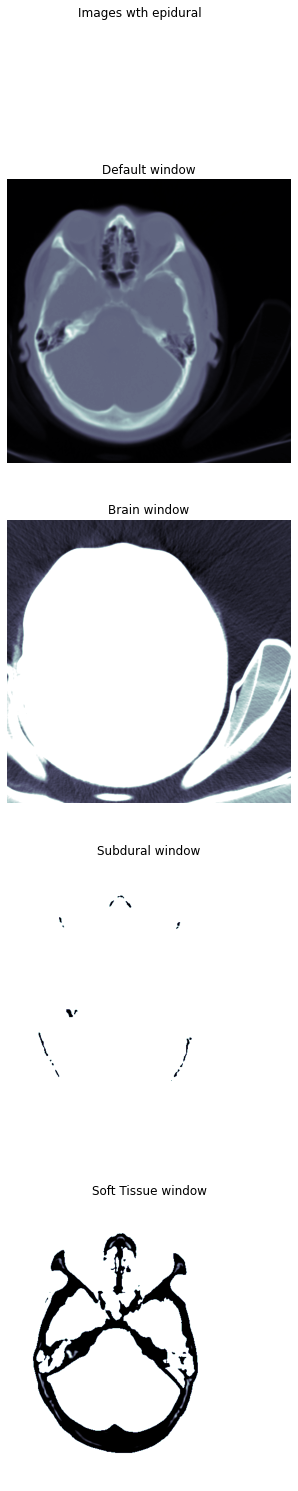

In [39]:
view_images(train_df[(train_df["subtype"] == 'epidural') & (train_df['label'] == 1)][:10].image.values, title='Images wth epidural')

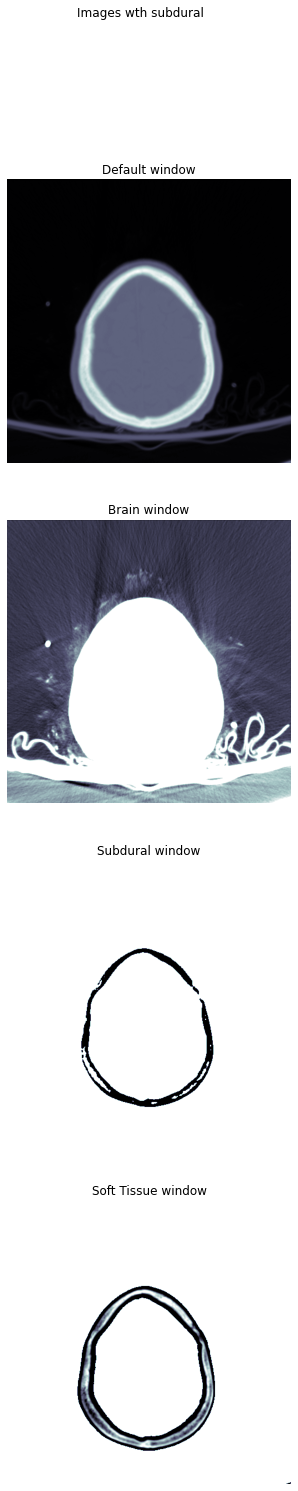

In [40]:
view_images(train_df[(train_df["subtype"] == 'subdural') & (train_df['label'] == 1)][:10].image.values, title='Images wth subdural')

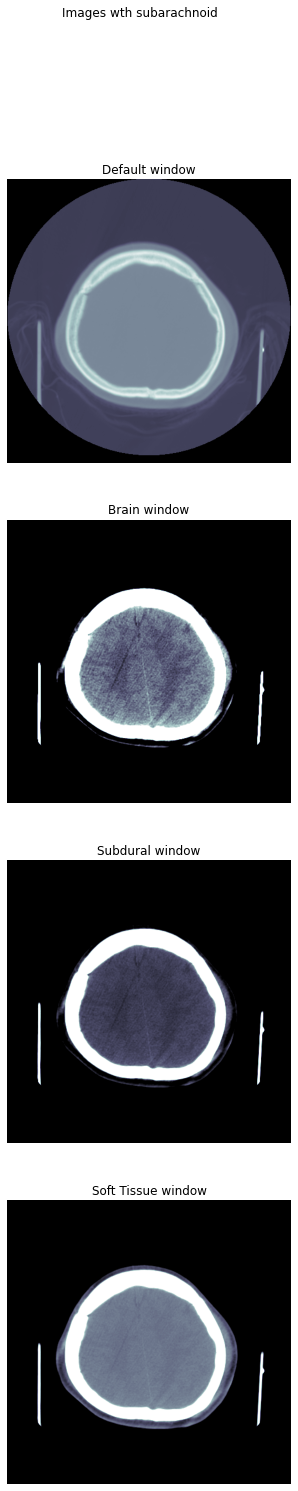

In [41]:
view_images(train_df[(train_df["subtype"] == 'subarachnoid') & (train_df['label'] == 1)][:10].image.values, title='Images wth subarachnoid')

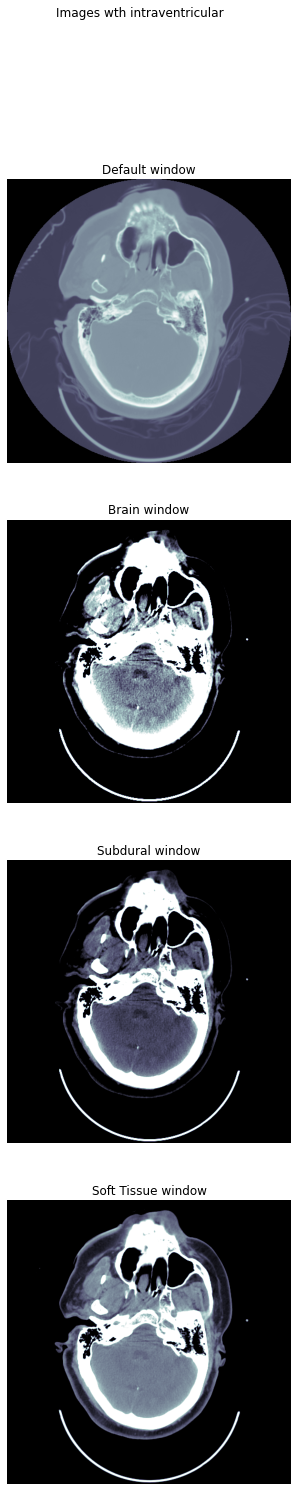

In [42]:
view_images(train_df[(train_df["subtype"] == 'intraventricular') & (train_df['label'] == 1)][:10].image.values, title='Images wth intraventricular')

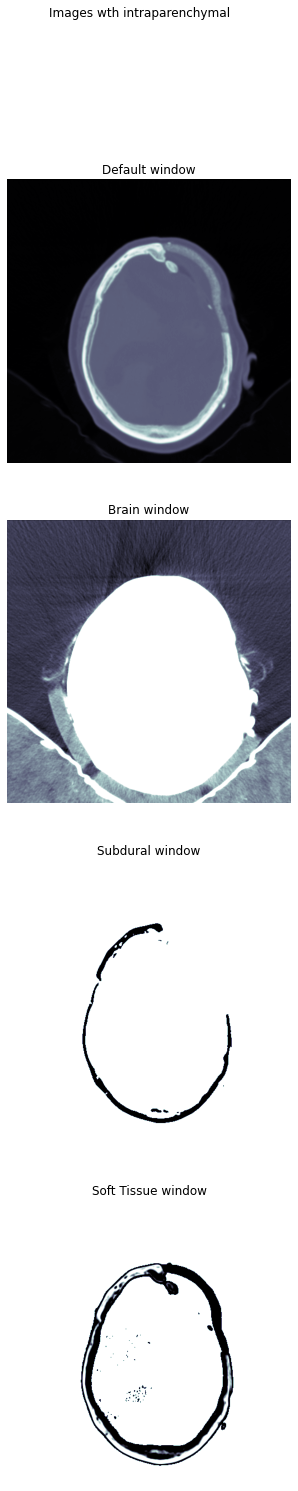

In [43]:
view_images(train_df[(train_df["subtype"] == 'intraparenchymal') & (train_df['label'] == 1)][:10].image.values, title='Images wth intraparenchymal')

### Combining the windows 

Lets take a random sample from the dataset to show the entire preprocessing would be

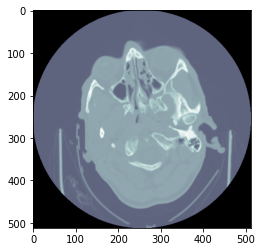

In [44]:
test_case = os.path.join(TRAIN_PATH,'ID_12cadc6af.dcm')

test_data = pydicom.read_file(test_case)
plt.imshow(test_data.pixel_array, cmap=plt.cm.bone)

Next, create the brain, subdural and soft tissue windows

In [45]:
brain_img = window_image(test_data, 40, 80)
subdural_img = window_image(dcm, 80, 200)
soft_img = window_image(dcm, 40, 380)

Before concatenating them, we need to make sure that all of theirvalues fall under a same range so we Standardise their values

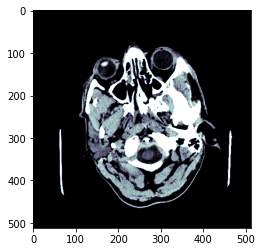

In [46]:
brain_img = (brain_img - 0) / 80
# print(brain_img)
plt.imshow(brain_img, cmap=plt.cm.bone)

[[-20. -20. -20. ... -20. -20. -20.]
 [-20. -20. -20. ... -20. -20. -20.]
 [-20. -20. -20. ... -20. -20. -20.]
 ...
 [-20. -20. -20. ... -20. -20. -20.]
 [-20. -20. -20. ... -20. -20. -20.]
 [-20. -20. -20. ... -20. -20. -20.]]


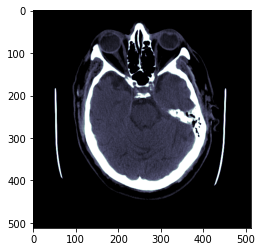

In [47]:
print(subdural_img)
plt.imshow(subdural_img, cmap=plt.cm.bone)

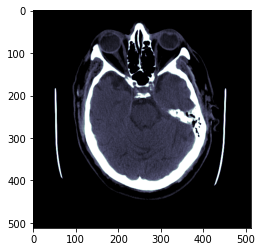

In [48]:
subdural_img = (subdural_img - (-20))/200
# print(subdural_img)
plt.imshow(subdural_img, cmap=plt.cm.bone)

[[-150. -150. -150. ... -150. -150. -150.]
 [-150. -150. -150. ... -150. -150. -150.]
 [-150. -150. -150. ... -150. -150. -150.]
 ...
 [-150. -150. -150. ... -150. -150. -150.]
 [-150. -150. -150. ... -150. -150. -150.]
 [-150. -150. -150. ... -150. -150. -150.]]


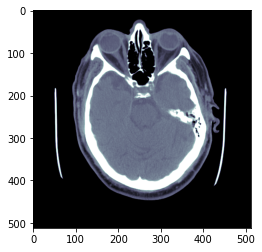

In [49]:
print(soft_img)
plt.imshow(soft_img, cmap=plt.cm.bone)

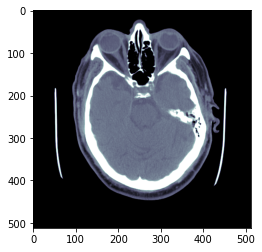

In [50]:
soft_img = (soft_img - (-150))/380
# print(soft_img)
plt.imshow(soft_img, cmap=plt.cm.bone)

So we brought all three windows to same scale, now we will combine them into a single 3-channel image

In [51]:
bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1, 2, 0)

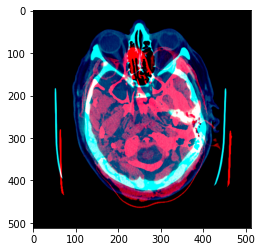

In [52]:
plt.imshow(bsb_img, cmap=plt.cm.bone)

# REFERENCES
[1. For DICOM related info ]( https://dicomiseasy.blogspot.com/2012/08/chapter-12-pixel-data.html)

[2. To understand CT scans and workflow of radiologists](https://radiopaedia.org/articles/ct-head-an-approach?lang=gb)

[3. Paper referred](https://arxiv.org/pdf/2008.00302.pdf)